In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import jax
import brainpy as bp
import brainpy.math as bm
import numpy as np
from TwoDCANN_utils import get_tuningMap
from TwoDCANN_utils import adaptiveCANN2D

from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
import numpy as np
import seaborn as sns

## Section 1: generate running trajectories in the open field using RatInABox

[]

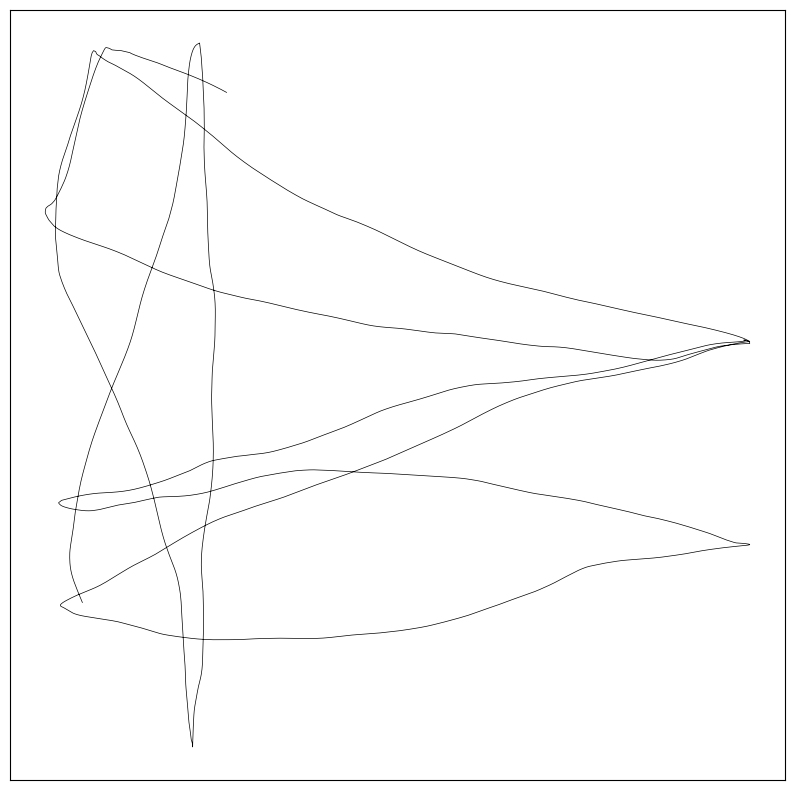

In [8]:
Env = Environment(params={
    'scale':2,
    "dimensionality": "2D",
})

dur = 60 #in seconds
dt = 0.001 #in seconds
speed_mean = 0.3 #in m/s
speed_std = 0.02 #in m/s
rotation_velocity_std = 30 * (np.pi / 180) #in rad/s

Ag = Agent(Env, params = {
    "dt": dt,
    "speed_mean":speed_mean,
    "speed_std": speed_std,
    "rotational_velocity_std": rotation_velocity_std, #set to 120 or 360 will change the tutoriocity of the trajectory
    })

while Ag.t < dur:
    Ag.update(drift_velocity=None,drift_to_random_strength_ratio=1)

# Ag.plot_trajectory()

# print(Ag.rotational_velocity_std)

Position = Ag.history['pos']
Position = np.array(Position)
# Position_2_2pi = Position*(2*np.pi)-np.pi
Vel = Ag.history['vel']
Speed = np.linalg.norm(Vel, axis=1)
# Speed_2_2pi = Speed*(2*np.pi)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Position[:,0], Position[:,1], linewidth=0.5, color='black')
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])

#save Position and Speed as a single npz indicating dur and speed_mean
#np.savez('./traces/TwoDtrajectory_dur'+str(dur)+'_speedMean'+str(speed_mean)+'.npz', Position=Position, Speed=Speed, Velocity=Vel, dur=dur)

## Section 2: Simulate the adaptive 2D CANN with anticipative tracking 

In [ ]:
bm.set_platform('gpu')
bm.set_dt(1.)

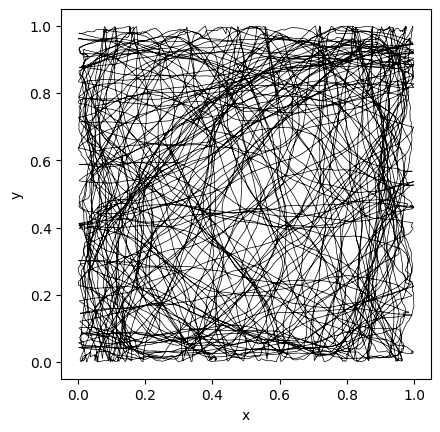

In [17]:
#load animal trajectory, which is simulated in 'geterate_trajectory.py' with the python toolbox: RatInABox
data = np.load('./traces/TwoDtrajectory_dur3600_speedMean0.05.npz')
positions = data['Position']
speeds = data['Speed']

#plot the trajectory
fig, ax = plt.subplots()
ax.plot(positions[:, 0], positions[:, 1], color='black', linewidth=0.5)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [18]:
# tracking
duration = 3600 #in seconds
samples_per_sec = 10 
dim = 40 #dimension of the network in each direction
m0=8 #adaptation strength
k=1 #gloabl inhibition strength
a=0.08 #half-width of the range of excitatory connections, indicating the place field width
z_min = 0; z_max = 1 #the size of the environment

#build the network
adapt_cann = adaptiveCANN2D(length=dim, m0=m0, k=k, z_min=z_min, z_max=z_max, a=a)

#prepare the input
position_x = bm.asarray(positions[:duration*samples_per_sec, 0])
position_y = bm.asarray(positions[:duration*samples_per_sec, 1])
positions = bm.stack([position_x, position_y]).T

Iext = jax.vmap(adapt_cann.get_stimulus_by_pos)(positions)

runner = bp.DSRunner(adapt_cann,
                     inputs=['input', Iext, 'iter'],
                     monitors=['r'])
runner.run(duration)

Predict 36000 steps: : 100%|██████████| 36000/36000 [00:04<00:00, 7251.35it/s]


#### animate the anticipative tracking effect

MovieWriter imagemagick unavailable; using Pillow instead.


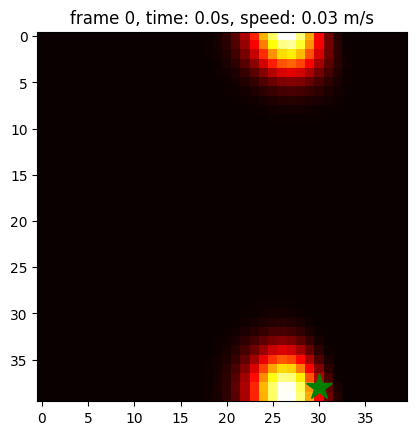

In [19]:
values = runner.mon.r.reshape((-1, dim, dim))
#make an animation
fig, ax = plt.subplots()

#recale the position_x and position_y to the range of the image
position_x_int = (position_x*dim).astype(int)
position_y_int = (position_y*dim).astype(int)

start = 1500
end = 2100
values = values[start:end]
position_x_int = position_x_int[start:end]
position_y_int = position_y_int[start:end]

def update(i):
    ax.clear()
    ax.plot(position_x_int[i], position_y_int[i], color='green', marker='*', markersize=20)
    ax.imshow(values[i], cmap='hot')
    ax.set_title(f'frame {i}, time: {np.round(i/10,2)}s, speed: {np.round(speeds[i],2)} m/s')
    return ax


ani = FuncAnimation(fig, update, frames=len(values), interval=100)

#save the animation to a file as a gif
ani.save('./animations/adapt2Dcann_ani_m'+str(m0)+'.gif', writer='imagemagick', fps=10)

## Section 2: Get the firing field of several place cells

#### prepare the data 

In [4]:
activity = runner.mon.r.reshape((-1, dim, dim))*100
data = np.load('./traces/TwoDtrajectory_dur3600_speedMean0.05.npz')
positions = data['Position'][:duration*samples_per_sec,:]

#### show exampled the animal's trajectory, firing rate map for one cell and the mean map

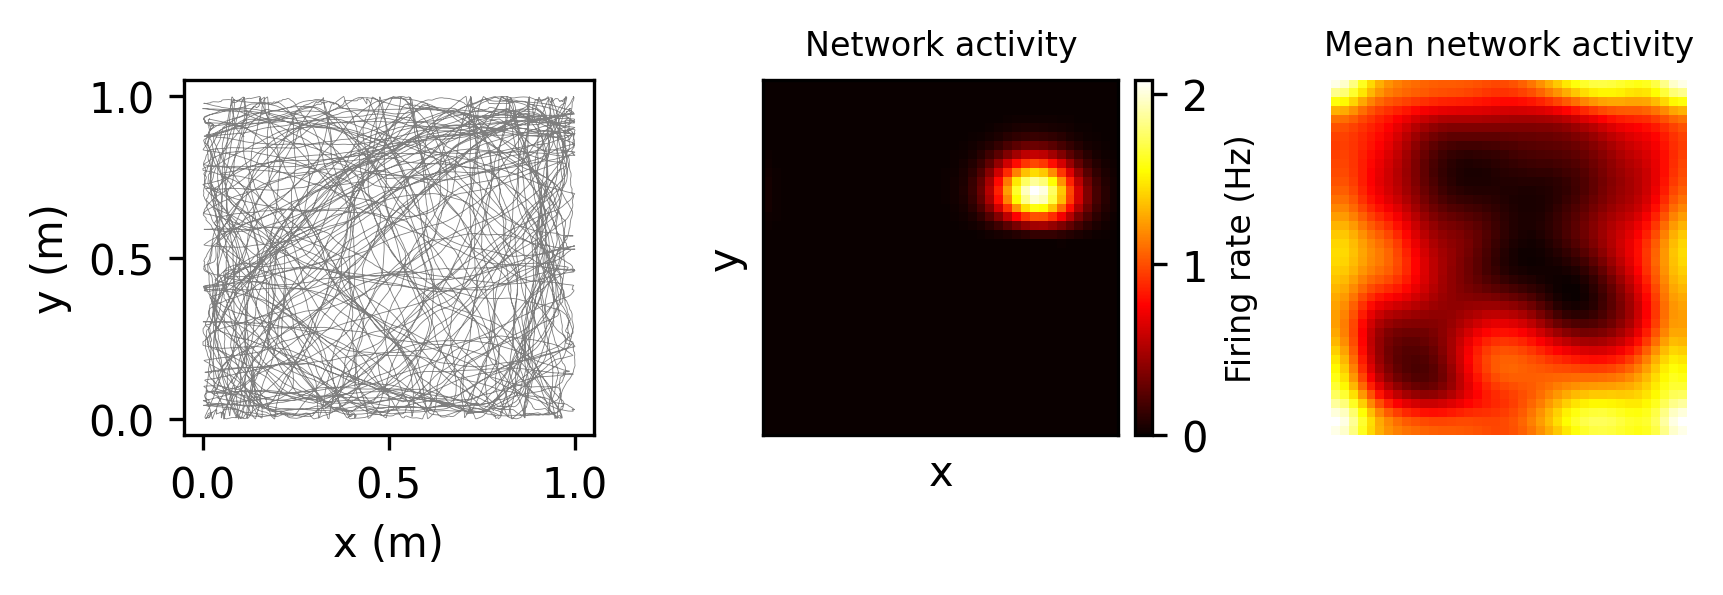

In [20]:
#plot all the firing rates in a single merged image
fig, axs = plt.subplots(1,3, figsize=(6,2), dpi=300)

ind=6000

#plot the trajectory
axs[0].plot(positions[:,0], positions[:,1], color='black', linewidth=0.2, alpha=0.5)
axs[0].set_xlabel('x (m)')
axs[0].set_ylabel('y (m)')


axs[1].imshow(activity[ind,:,:], cmap='hot')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Network activity', fontsize=8)
cbar = plt.colorbar(axs[1].imshow(activity[ind,:,:], cmap='hot'), ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Firing rate (Hz)', fontsize=8)

axs[2].imshow(activity.mean(axis=0), cmap='hot')
axs[2].axis('off')
axs[2].set_title('Mean network activity', fontsize=8)


plt.tight_layout()

plt.savefig('./figures/meanactivitymap.png', dpi=300)

#### show the firing curves of several exampled cells 

Text(0.06, 0.5, 'Cell ids')

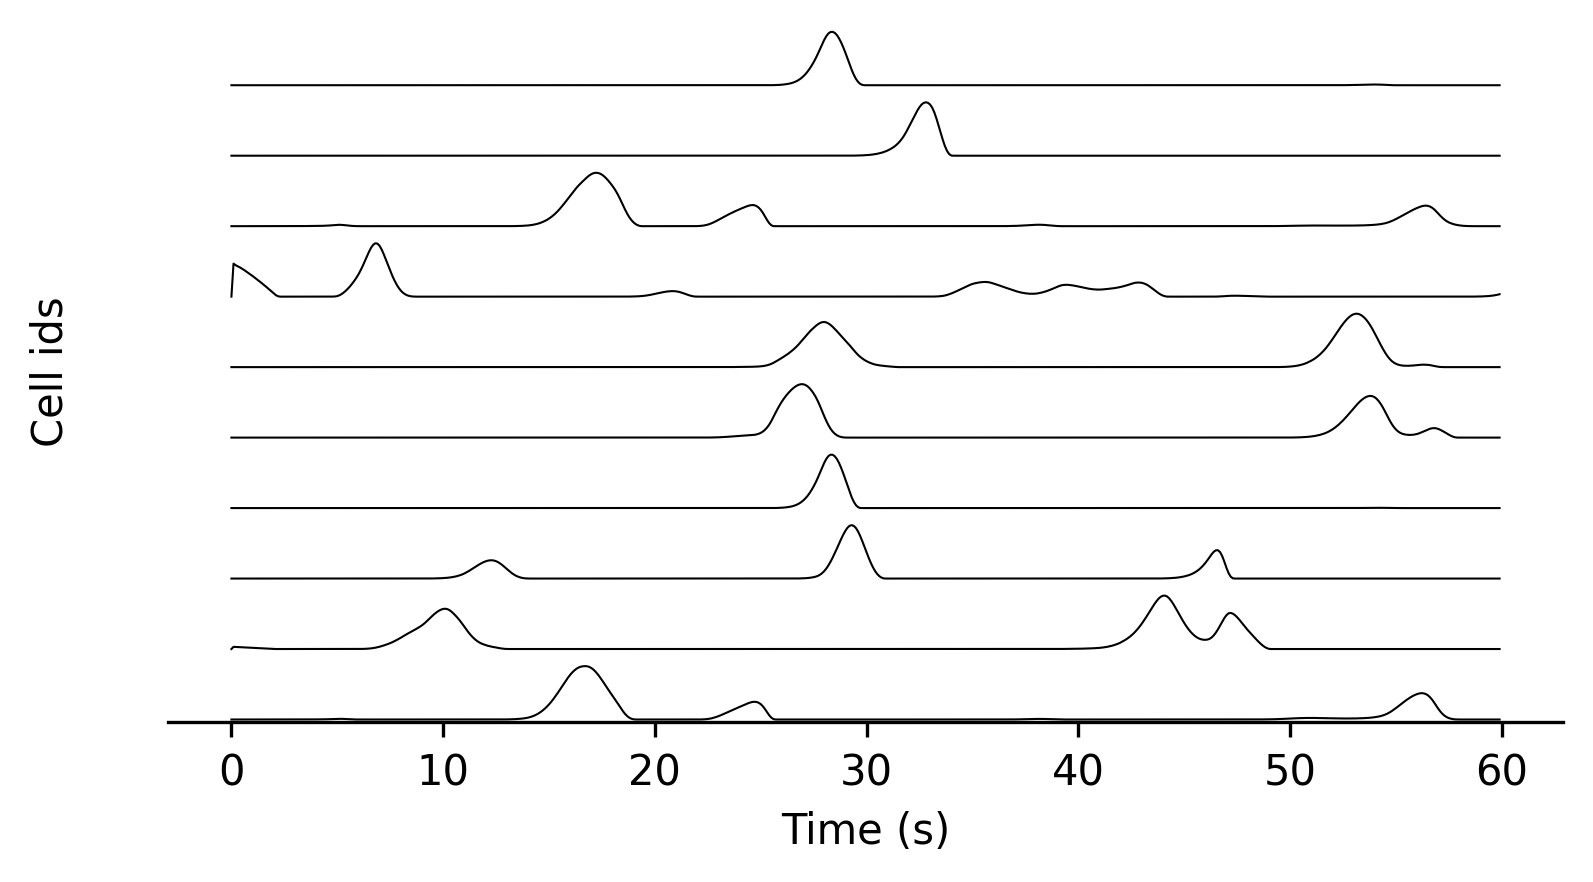

In [5]:
cellindex_x = dim//2; cellindex_y = dim//2
firing_curve = activity[:, cellindex_x, cellindex_y]

Nsamples = 10
dur = 60 #duration of visualisation in seconds
#random sampling 10 positions in between 10-20 indexes alomng two dimensions
cellindex_x = np.random.randint(5, 35, Nsamples)
cellindex_y = np.random.randint(5, 35, Nsamples)

#plot Nsamples firing curves
fig, axs = plt.subplots(Nsamples, 1, figsize=(6, 3), dpi=300)

for i in range(Nsamples):
    ind_x = cellindex_x[i]
    ind_y = cellindex_y[i]
    firing_curve = activity[:dur*samples_per_sec, ind_x, ind_y]
    axs[i].plot(np.arange(0,dur,1/samples_per_sec), firing_curve, color='black', linewidth=0.5)
    if i<Nsamples-1:
        axs[i].axis('off')
    else:
        axs[i].set_xlabel('Time (s)')
        #top and right and left spines are removed
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        #y axis is removed
        axs[i].yaxis.set_visible(False)

#add an overall xlabel and y label

fig.text(0.06, 0.5, 'Cell ids', ha='center', va='center', rotation='vertical')

#### exmaple code of finding the patches

In [6]:
from TwoDCANN_utils import find_patches
# Example array
array = np.array([[1, 0, 0, 1, 1],
                  [0, 1, 1, 1, 0],
                  [0, 1, 1, 1, 0],
                  [0, 0, 0, 0, 1]])

# Find patches
patches = find_patches(array)

# Print patches
for idx, patch in enumerate(patches, 1):
    print(f"Patch {idx}:\n{np.array([[1 if (i, j) in patch else 0 for j in range(array.shape[1])] for i in range(array.shape[0])])}\n")


Patch 1:
[[0 0 0 1 1]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]

Patch 2:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 1]]

Patch 3:
[[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]



#### get the tuning map and map criteria of simulated cells with activity shift (both negative and positive)

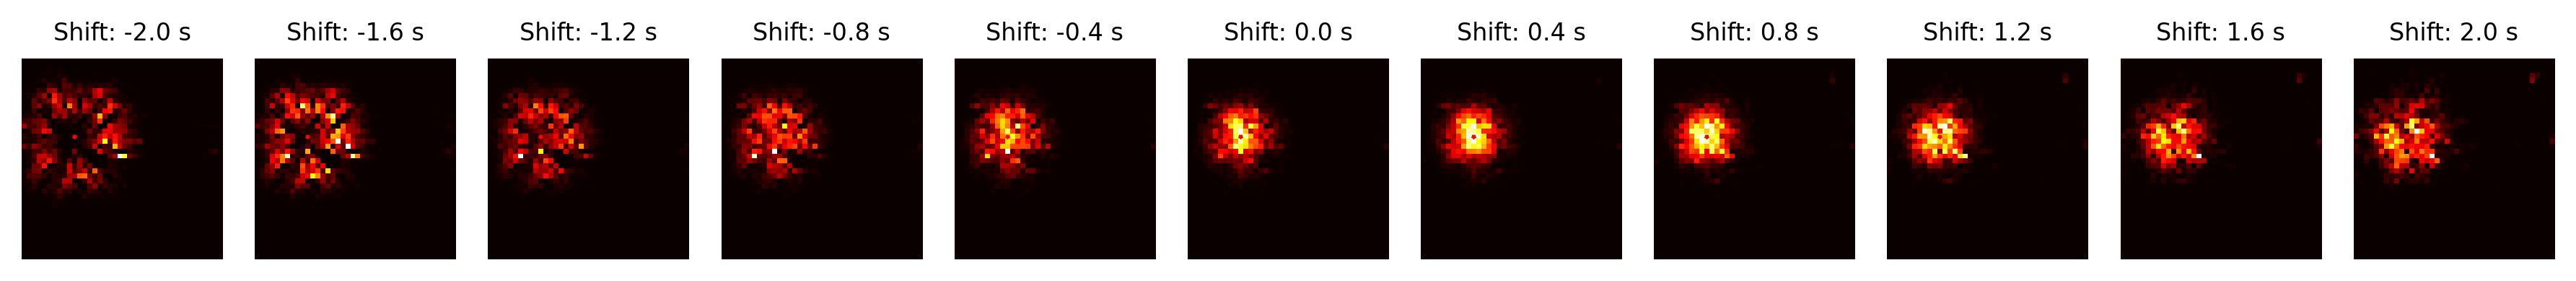

In [7]:
cellindex_x = 10; cellindex_y = 15
shifts = np.arange(-20, 24, 4)

fig, axs = plt.subplots(1, len(shifts), figsize=(12, 3), dpi=300)

for id, shift in enumerate(shifts):
    tuning_map, map_criteria = get_tuningMap(activity, positions, cellindex_x, cellindex_y, shift, filter=False, firing_rate_thres=0.2, samples_per_sec=10, dim=dim)
    
    #plot
    axs[id].imshow(tuning_map, cmap='hot')
    axs[id].set_xlabel('x')
    axs[id].set_ylabel('y')
    #ticks from 0-1
    axs[id].set_xticks([0, 20, 40])
    axs[id].set_yticks([0, 20, 40])
    axs[id].set_xticklabels([0, 0.5, 1])
    axs[id].set_yticklabels([0, 0.5, 1])
    axs[id].set_title(f'Shift: {shift/10} s', fontsize=8)
    axs[id].axis('off')
    #add (cellindex_x, cellindex_y) as a marker on the map
    axs[id].plot(cellindex_x, cellindex_y, color='red', marker='*', markersize=1)

plt.tight_layout()
plt.savefig('./figures/tuning_map_shifts.png', dpi=300)

### an example cell's map criteria with activity shift

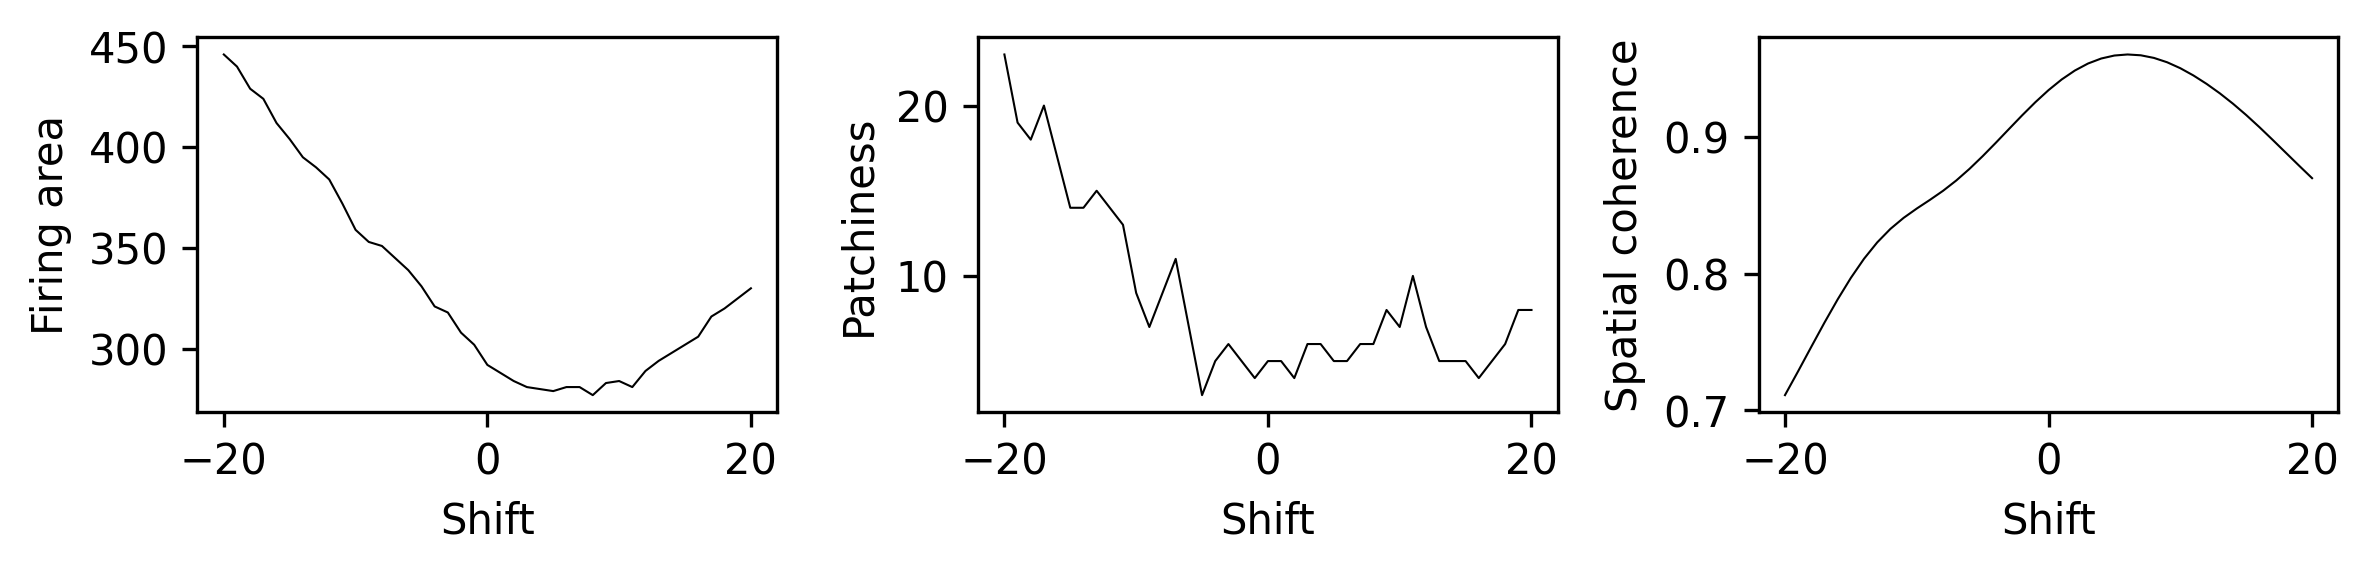

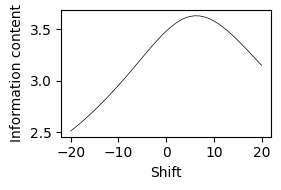

In [21]:
cellindex_x = 20; cellindex_y = 20
shifts = np.arange(-20, 21, 1)

Shift_Firing_Area = []
Patchiness = []
Spatial_Coherence = []
Spatial_Information_Content = []
for id, shift in enumerate(shifts):
    tuning_map, map_criteria = get_tuningMap(activity, positions, cellindex_x, cellindex_y, shift, filter=False, firing_rate_thres=0.2, samples_per_sec=10, dim=dim)
    
    Shift_Firing_Area = np.append(Shift_Firing_Area, map_criteria['firing_area'])
    Patchiness = np.append(Patchiness, map_criteria['patchiness'])
    Spatial_Coherence = np.append(Spatial_Coherence, map_criteria['spatial_coherence'])
    Spatial_Information_Content = np.append(Spatial_Information_Content, map_criteria['spatial_information_content'])

fig, axs = plt.subplots(1, 3, figsize=(8, 2), dpi=300)
#plot the firing area as a function of the shift
axs[0].plot(shifts, Shift_Firing_Area, color='black', linewidth=0.5)
axs[0].set_xlabel('Shift')
axs[0].set_ylabel('Firing area')

#plot the patchiness as a function of the shift
axs[1].plot(shifts, Patchiness, color='black', linewidth=0.5)
axs[1].set_xlabel('Shift')
axs[1].set_ylabel('Patchiness')

#plot the spatial coherence as a function of the shift
axs[2].plot(shifts, Spatial_Coherence, color='black', linewidth=0.5)
axs[2].set_xlabel('Shift')
axs[2].set_ylabel('Spatial coherence')

plt.tight_layout()

plt.savefig('./figures/shift_analysis_4_examplecell.png', dpi=300)

fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=100)
#plot the spatial information content as a function of the shift
ax.plot(shifts, Spatial_Information_Content, color='black', linewidth=0.5)
ax.set_xlabel('Shift')
ax.set_ylabel('Information content')
plt.tight_layout()
plt.savefig('./figures/spatial_information_content_4_examplecell.png')

#### many cells' map criteria with activity shift

In [22]:
#preparing the data
activity = runner.mon.r.reshape((-1, dim, dim))*100
data = np.load('./traces/TwoDtrajectory_dur3600_speedMean0.05.npz')
positions = data['Position'][:duration*samples_per_sec,:]

Nsamples = 100
#random sampling 10 positions in between 10-20 indexes alomng two dimensions
cellindex_x = np.random.randint(5, 35, Nsamples)
cellindex_y = np.random.randint(5, 35, Nsamples)

#for each cell, calculate the shift map
Shift_Firing_Area_4_all_cells = []
Patchiness_for_all_cells = []
Spatial_Coherence_for_all_cells = []
Spatial_Information_Content_for_all_cells = []

for i in range(Nsamples):
    ind_x = cellindex_x[i]
    ind_y = cellindex_y[i]
    
    shifts = np.arange(-30, 31, 1)
    Shift_Firing_Area_4_cell = []
    Patchiness_4_cell = []
    Spatial_Coherence_4_cell = []
    Spatial_Information_Content_4_cell = []
    for id, shift in enumerate(shifts):
        tuning_map, map_criteria = get_tuningMap(activity, positions, ind_x, ind_y, shift, filter=False, firing_rate_thres=0.2, samples_per_sec=10, dim=dim)
        Shift_Firing_Area_4_cell = np.append(Shift_Firing_Area_4_cell, map_criteria['firing_area'])
        Patchiness_4_cell = np.append(Patchiness_4_cell, map_criteria['patchiness'])
        Spatial_Coherence_4_cell = np.append(Spatial_Coherence_4_cell, map_criteria['spatial_coherence'])
        Spatial_Information_Content_4_cell = np.append(Spatial_Information_Content_4_cell, map_criteria['spatial_information_content'])
        
    Shift_Firing_Area_4_all_cells.append(Shift_Firing_Area_4_cell)
    Patchiness_for_all_cells.append(Patchiness_4_cell)
    Spatial_Coherence_for_all_cells.append(Spatial_Coherence_4_cell)
    Spatial_Information_Content_for_all_cells.append(Spatial_Information_Content_4_cell)

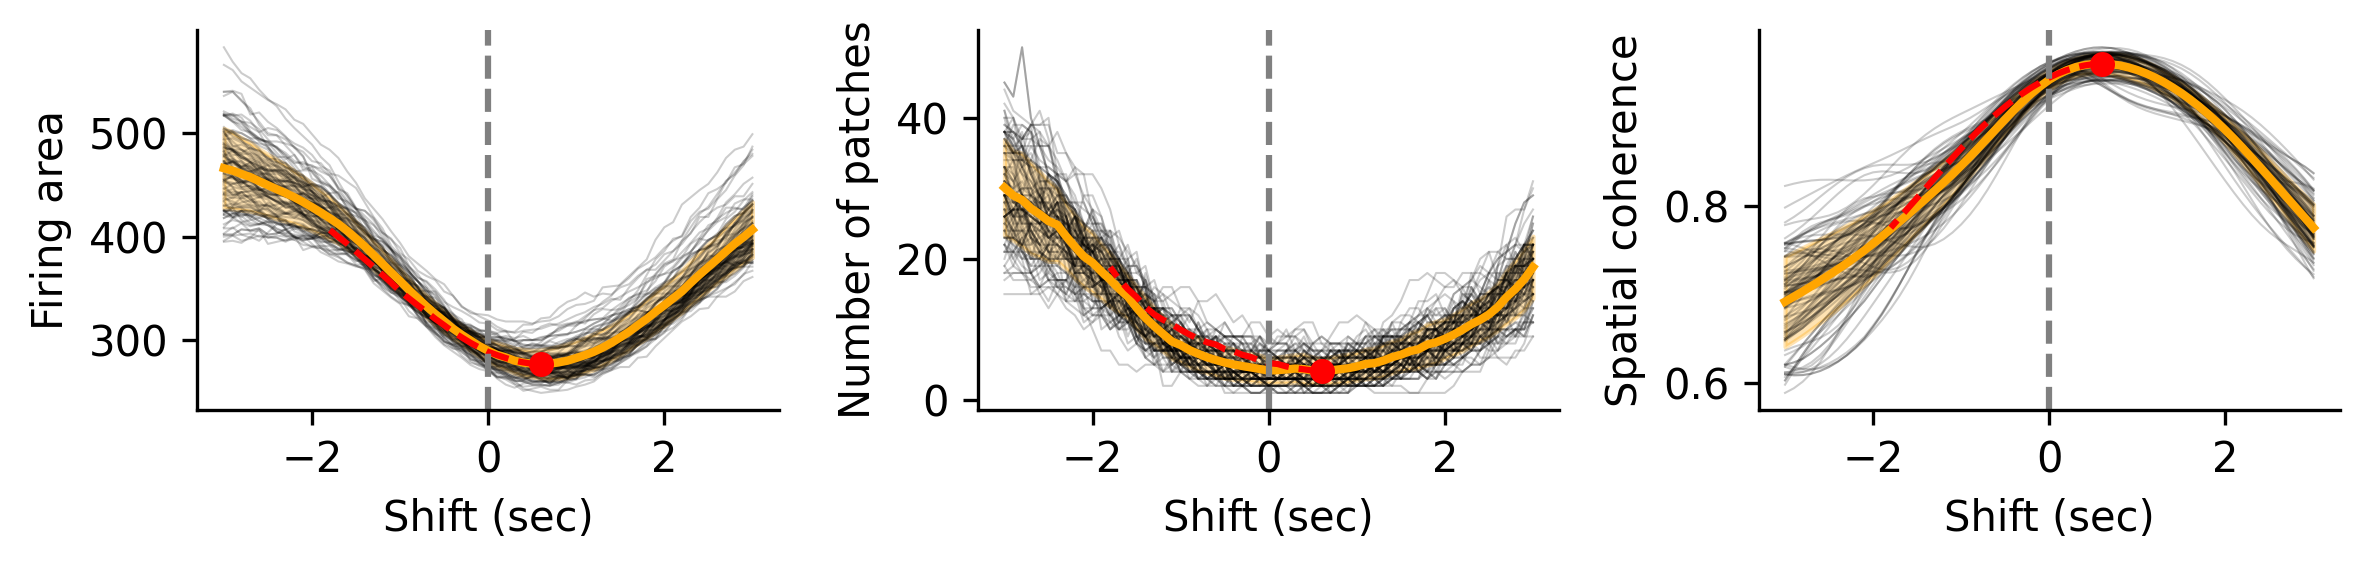

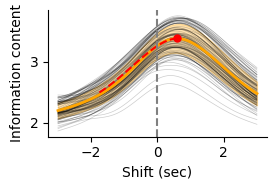

In [23]:
#Plot the shift firing area for all cells
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(8, 2), dpi=300)


#1, plot the firing area
for i in range(Nsamples):
    ax1.plot(shifts/10, Shift_Firing_Area_4_all_cells[i], color='black', linewidth=0.5, alpha=0.2)
    
#get the mean and std of the firing area
Shift_Firing_Area_4_all_cells = np.asarray(Shift_Firing_Area_4_all_cells)
mean = np.mean(Shift_Firing_Area_4_all_cells, axis=0)
std = np.std(Shift_Firing_Area_4_all_cells, axis=0)

#plot the mean and add std as the shaded area
ax1.plot(shifts/10, mean, linewidth=2, color='orange')
ax1.fill_between(shifts/10, mean-std, mean+std, color='orange', alpha=0.3)

#find the minima of the firing area and reflect the right half to the left as a red dashed line
minima = np.argmin(mean)
#mark the minima as a red point
ax1.plot(shifts[minima]/10, mean[minima], color='red', marker='o', markersize=5)
#mirror the right half from the minima until the end
x = shifts[minima:]
#mirror x values with respect to shifts[minima]
x = 2*shifts[minima] - x
y = mean[minima:]
#mirror the right half from the minima until the end to the left
ax1.plot(x/10, y, color='red', linestyle='--')

#mark x=0 as a black dashed line
ax1.axvline(x=0, color='grey', linestyle='--')

ax1.set_xlabel('Shift (sec)')
ax1.set_ylabel('Firing area')

#spines are removed
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#2, plot the patchiness
for i in range(Nsamples):
    ax2.plot(shifts/10, Patchiness_for_all_cells[i], color='black', linewidth=0.5, alpha=0.2)

#get the mean and std of the patchiness
Patchiness_for_all_cells = np.asarray(Patchiness_for_all_cells)
mean = np.mean(Patchiness_for_all_cells, axis=0)
std = np.std(Patchiness_for_all_cells, axis=0)

#plot the mean and add std as the shaded area
ax2.plot(shifts/10, mean, linewidth=2, color='orange')
ax2.fill_between(shifts/10, mean-std, mean+std, color='orange', alpha=0.3)

#find the minima of the patchiness and reflect the right half to the left as a red dashed line
minima = np.argmin(mean)
#mark the minima as a red point
ax2.plot(shifts[minima]/10, mean[minima], color='red', marker='o', markersize=5)
#mirror the right half from the minima until the end
x = shifts[minima:]
#mirror x values with respect to shifts[minima]
x = 2*shifts[minima] - x

y = mean[minima:]
#mirror the right half from the minima until the end to the left
ax2.plot(x/10, y, color='red', linestyle='--')

#mark x=0 as a black dashed line
ax2.axvline(x=0, color='grey', linestyle='--')

ax2.set_xlabel('Shift (sec)')
ax2.set_ylabel('Number of patches')

#spines are removed
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#3, plot the spatial coherence
for i in range(Nsamples):
    ax3.plot(shifts/10, Spatial_Coherence_for_all_cells[i], color='black', linewidth=0.5, alpha=0.2)
    
#get the mean and std of the spatial coherence
Spatial_Coherence_for_all_cells = np.asarray(Spatial_Coherence_for_all_cells)
mean = np.mean(Spatial_Coherence_for_all_cells, axis=0)
std = np.std(Spatial_Coherence_for_all_cells, axis=0)

#plot the mean and add std as the shaded area
ax3.plot(shifts/10, mean, linewidth=2, color='orange')
ax3.fill_between(shifts/10, mean-std, mean+std, color='orange', alpha=0.3)

#find the max of the firing area and reflect the right half to the left as a red dashed line
maxima = np.argmax(mean)
#mark the maxima as a red point
ax3.plot(shifts[maxima]/10, mean[maxima], color='red', marker='o', markersize=5)
#mirror the right half from the maxima until the end
x = shifts[maxima:]
#mirror x values with respect to shifts[maxima]
x = 2*shifts[maxima] - x
y = mean[maxima:]
#mirror the right half from the maxima until the end to the left
ax3.plot(x/10, y, color='red', linestyle='--')
    
#mark x=0 as a black dashed line
ax3.axvline(x=0, color='grey', linestyle='--')

ax3.set_xlabel('Shift (sec)')
ax3.set_ylabel('Spatial coherence')

#spines are removed
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/shift_analysis_4_all_cells.png', dpi=300)

############################################################################################################
#plot the spatial information content for all cells in a new figure
fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=100)
#plot the spatial information content as a function of the shift
for i in range(Nsamples):
    ax.plot(shifts/10, Spatial_Information_Content_for_all_cells[i], color='black', linewidth=0.5, alpha=0.2)
    
#get the mean and std of the spatial information content
Spatial_Information_Content_for_all_cells = np.asarray(Spatial_Information_Content_for_all_cells)
mean = np.mean(Spatial_Information_Content_for_all_cells, axis=0)
std = np.std(Spatial_Information_Content_for_all_cells, axis=0)

#plot the mean and add std as the shaded area
ax.plot(shifts/10, mean, linewidth=2, color='orange')
ax.fill_between(shifts/10, mean-std, mean+std, color='orange', alpha=0.3)

#find the max of the firing area and reflect the right half to the left as a red dashed line
maxima = np.argmax(mean)
#mark the maxima as a red point
ax.plot(shifts[maxima]/10, mean[maxima], color='red', marker='o', markersize=5)
#mirror the right half from the maxima until the end
x = shifts[maxima:]

#mirror x values with respect to shifts[maxima]
x = 2*shifts[maxima] - x
y = mean[maxima:]
#mirror the right half from the maxima until the end to the left
ax.plot(x/10, y, color='red', linestyle='--')

#mark x=0 as a black dashed line
ax.axvline(x=0, color='grey', linestyle='--')

ax.set_xlabel('Shift (sec)')
ax.set_ylabel('Information content')

#spines are removed
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig('./figures/spatial_information_content_4_all_cells.png', dpi=300)